In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# package settings
np.random.seed(42)

import perc
from perc.utils import calc_total_heat, get_adiab_IC, get_benchmarks
import perc.vis as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [11]:
### Data Constants
DT = 0.01
NX = 50
NUM_TRAJ = 5
TN = 2.0
L = 1.0
ALPHA = 0.025 # thermal diffusivity
TOTAL_HEAT = 0.3

### RC Configuration
EPS = 10 # number of steps to spin up the reservoir when predicting on new trajectory
RC_CONFIG = {
    'Nu': NX,
    'Nr': 100,
    'alpha': 0.6,
    'beta': 8e-8,
    'rho_A': 0.02,
    'lambda_max': 0.9,
    'sigma': 0.005,
    'bias': 0.0,
    'spinup': EPS,
    'f': np.tanh
}

# Load data 

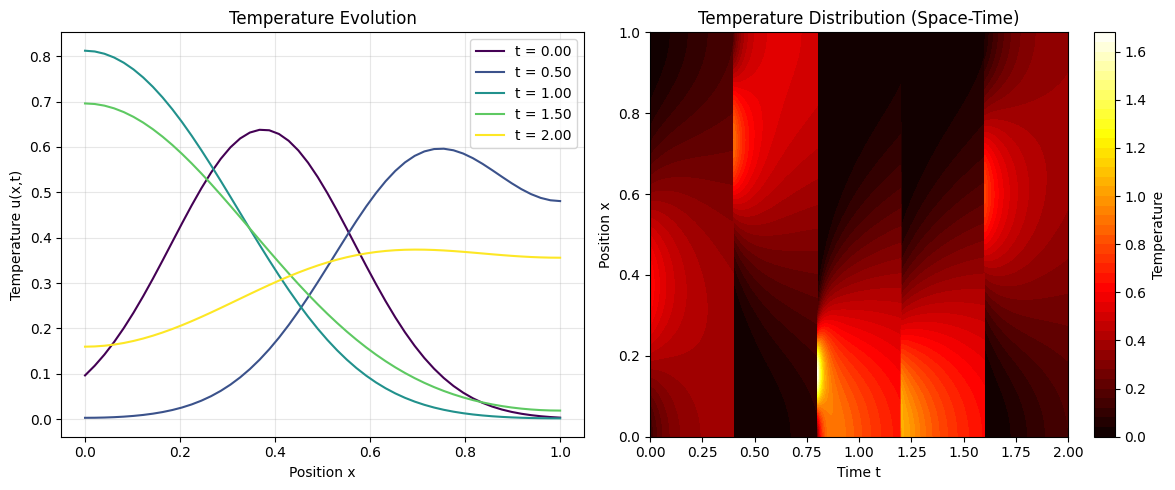

In [12]:
### Generate several trajectories of the heat equation and combine them into a training set
x = np.linspace(0, L, NX)
U_lst = []
for i in range(NUM_TRAJ+1):
    peak_loc = np.random.uniform(0, L)
    peak_width = np.random.uniform(0.05, 0.2) 
    a = {'center': peak_loc, 'width': peak_width, 'shape': 2.0}
    u0 = get_adiab_IC(a, TOTAL_HEAT, NX, L=L)
    u = perc.integrators.heat_eq_1D_adiab(u0,TN,DT,NX,ALPHA)
    U_lst.append(u)
U_test = U_lst[-1]
U_lst = U_lst[:-1]  # Remove the last one for testing
U_train = np.concatenate(U_lst, axis=1)

# burn in set 
U_burn_in = U_test[:, :EPS]
U_test = U_test[:, EPS:]
t_test = np.arange(0, U_test.shape[1] * DT, DT)

vis.visualize_heat_equation(U_train,
                        tN=TN,
                        L=L)
plt.show()

In [13]:
### Process data

# linear constraints
C = np.ones((1, NX))
C[:, 1:-1] = 2.0
dx = L / (NX - 1)
C = dx/2.0 * C # trapezoidal to calculate total heat
d = np.array([TOTAL_HEAT])[:,None]

# check constraint
print("Constraint check:", np.allclose(C@U_test, calc_total_heat(U_test)))

# print shapes 
print(f"U_train shape: {U_train.shape}")
print(f"U_test shape: {U_test.shape}")

# calc error on test set
C_err_utest = np.sum(np.abs((C@U_test - d)), axis=0).reshape(-1)

Constraint check: True
U_train shape: (50, 1005)
U_test shape: (50, 191)


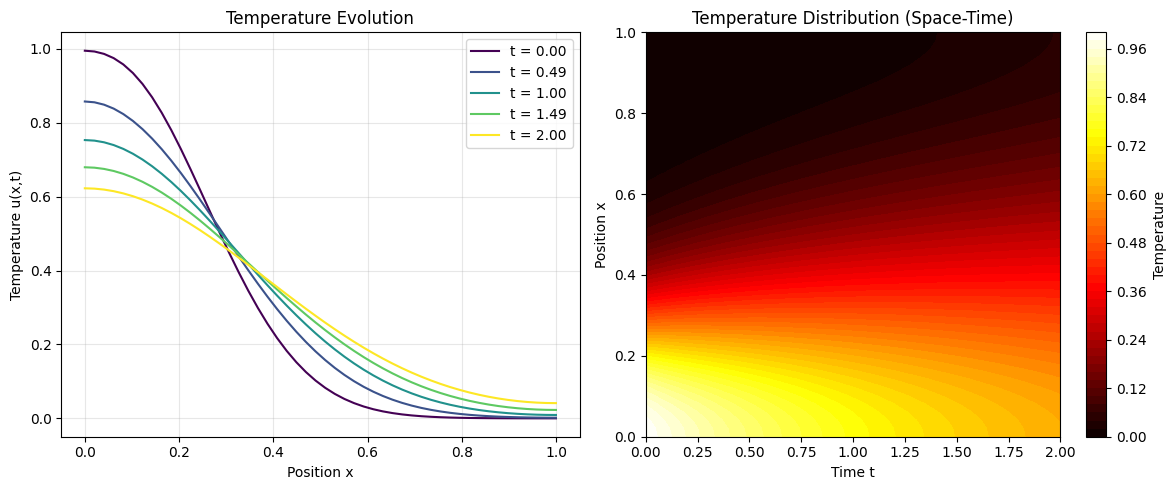

In [14]:
### Show test set 
vis.visualize_heat_equation(U_test,
                        tN=TN,
                        L=L)
plt.show()

# Train Unconstrained RC

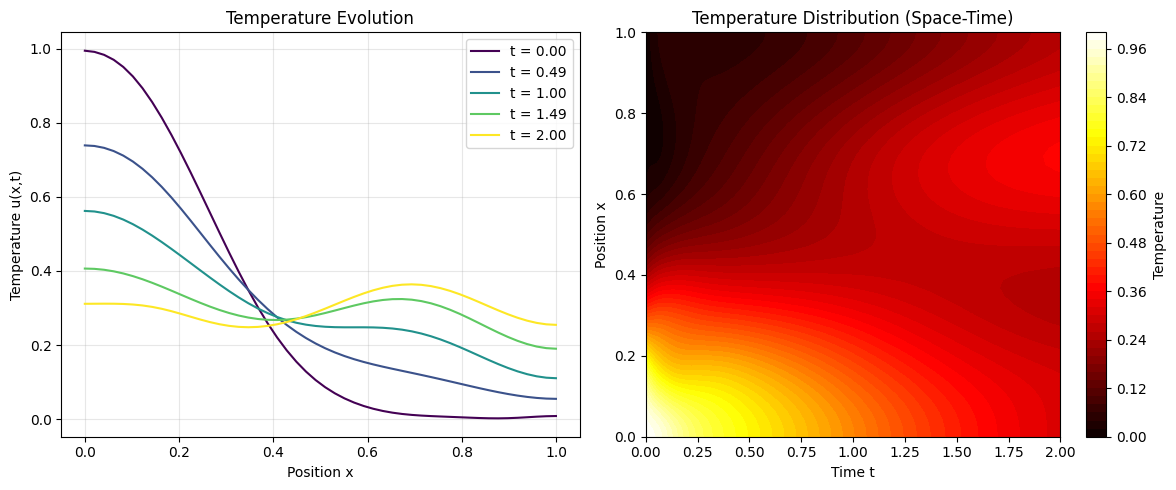

In [15]:
### Train Unconstrained RC ###
RC = perc.ReservoirComputer(**RC_CONFIG)
_ = RC.train(U_train)
U_pred = RC.forecast_from_IC(U_test.shape[1], IC = U_burn_in)

C_err_uc = np.sum(np.abs((C@U_pred - d)), axis=0).reshape(-1)
bm_uc = get_benchmarks(U_test, U_pred)

# visualize error 
vis.visualize_heat_equation(U_pred,
                        tN=TN,
                        L=L)
plt.show()

# Train Constrained RC

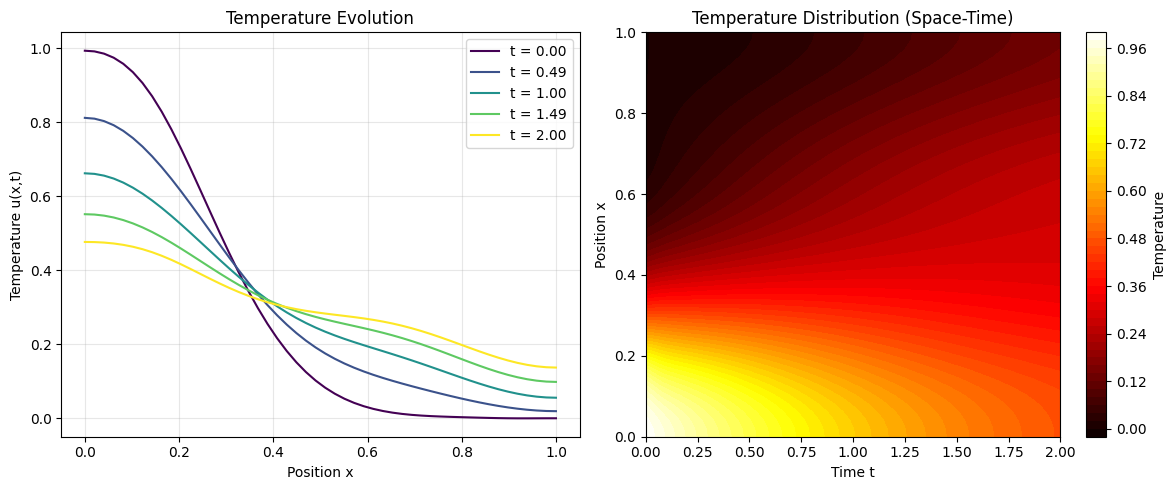

In [16]:
### Train Constrained RC ###
RC = perc.ReservoirComputer(**RC_CONFIG)
_ = RC.train_lih(U_train,C,d,
                     solver = cp.CLARABEL,
                     warm_start = True)
U_pred = RC.forecast_from_IC_lih(U_test.shape[1], IC = U_burn_in)[:-1,:]

C_err_c = np.sum(np.abs((C@U_pred - d)), axis=0).reshape(-1)
bm_c = get_benchmarks(U_test, U_pred)

vis.visualize_heat_equation(U_pred,
                        tN=TN,
                        L=L)
plt.show()

# Compare Errors 

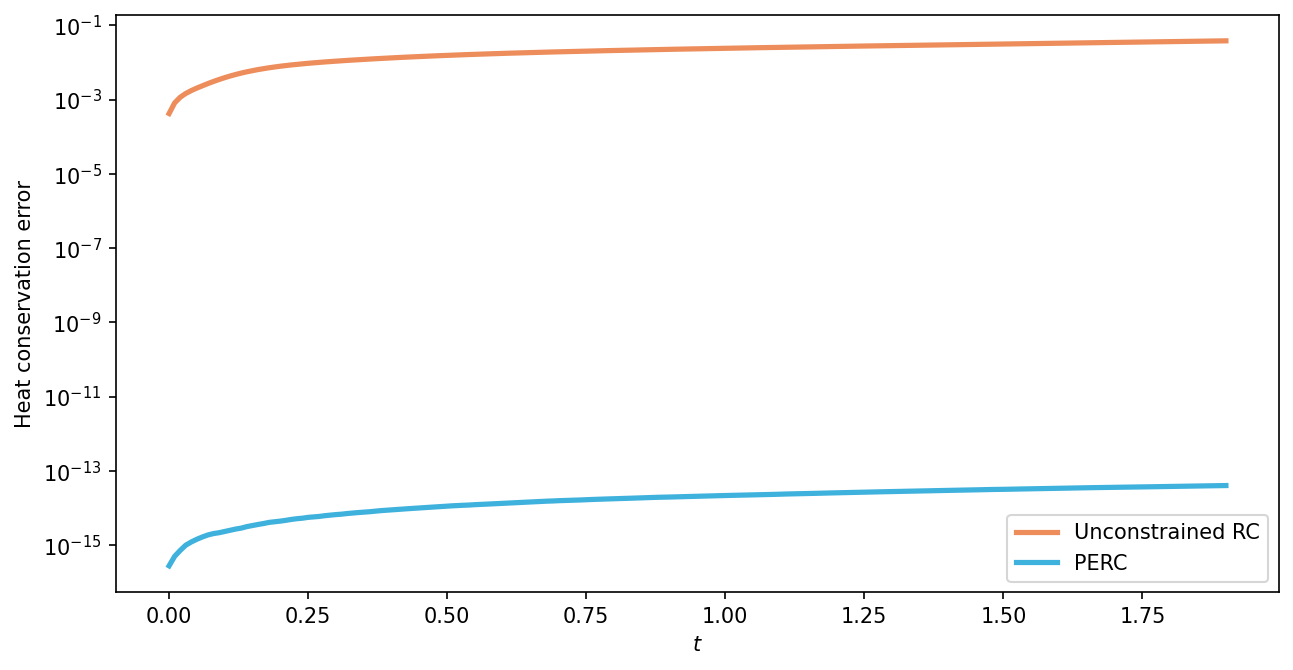

In [17]:
# make err cumulative
C_err_utest = np.cumsum(np.abs(C_err_utest))
C_err_uc = np.cumsum(np.abs(C_err_uc))
C_err_c = np.cumsum(np.abs(C_err_c))

# plot
lw = 2.5
UCRC_color = "#ed8d5b"
PERC_color = "#3fb1dd"
plt.figure(figsize=(10,5), dpi=150)
plt.plot(t_test, C_err_uc, label = 'Unconstrained RC', linewidth=lw, color=UCRC_color)
plt.plot(t_test, C_err_c, label = 'PERC', linewidth=lw, color=PERC_color)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel('Heat conservation error')
plt.show()

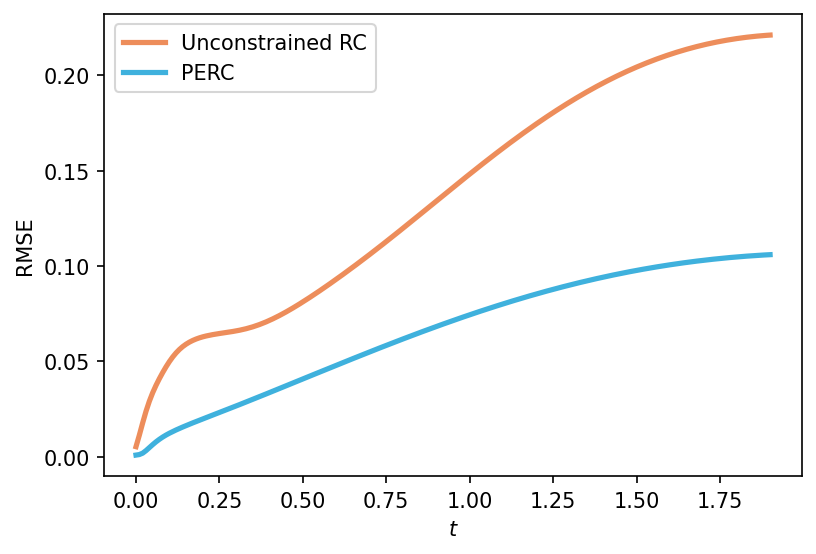

In [18]:
# plot benchmarks
bm_name = 'rmse'
lw = 2.5
UCRC_color = "#ed8d5b"
PERC_color = "#3fb1dd"
plt.figure(figsize=(6,4), dpi=150)
plt.plot(t_test, bm_uc[bm_name], label = "Unconstrained RC", linewidth=lw, color=UCRC_color)
plt.plot(t_test, bm_c[bm_name], label = "PERC", linewidth=lw, color=PERC_color)
plt.xlabel(r'$t$')
plt.ylabel(bm_name.upper())
plt.legend()
if "cumul" in bm_name:
    plt.yscale('log')
plt.show()